# ÖDEV 1: PCA yardımı ile Classification

Bu ödevde "Credit Risk Prediction" veri setini kullanacağız. Amacımız, verinin boyut sayısını düşürerek olabildiğince yüksek accuracy değerini alabilmek. Aşağıda verinin okunma ve temizlenme kısmını hazırlayıp vereceğim. Devamında ise yapmanız gerekenler:

1. PCA kullanarak verinin boyutunu düşürmek
    * Önce explained varience ratio değerini inceleyerek veriyi kaç boyuta düşürebileceğini kontrol et.
    * Daha sonra farklı boyutlarda denemeler yaparak boyutu düşürülmüş verileri elde et.
2. Classification modellerini dene
    * Logistic Regression
    * Random Forest
    * ve eğer istersen herhangi bir modelle daha

İsteğe bağlı olarak, verinin boyutunu düşürmek için diğer yöntemleri de kullanıp en yüksek accuracy değerini almayı deneyebilirsin.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from atpbar import atpbar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

In [2]:
#read the data
df = pd.read_csv('./credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# Null değerleri sütun ortalaması ile dolduruyoruz
#df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)
#df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

In [4]:
#number of the duplicated rows
df.duplicated().sum()

165

In [5]:
#drop duplicated rows
df = df.drop_duplicates()

In [6]:
#null values in the features
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,31529.0,4.790510,4.145490,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,29321.0,11.017265,3.241680,5.42,7.90,10.99,13.47,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [9]:
#name of the numeric columns
df.select_dtypes(np.number).columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

In [10]:
#number of numeric columns
len(df.select_dtypes(np.number).columns)

8

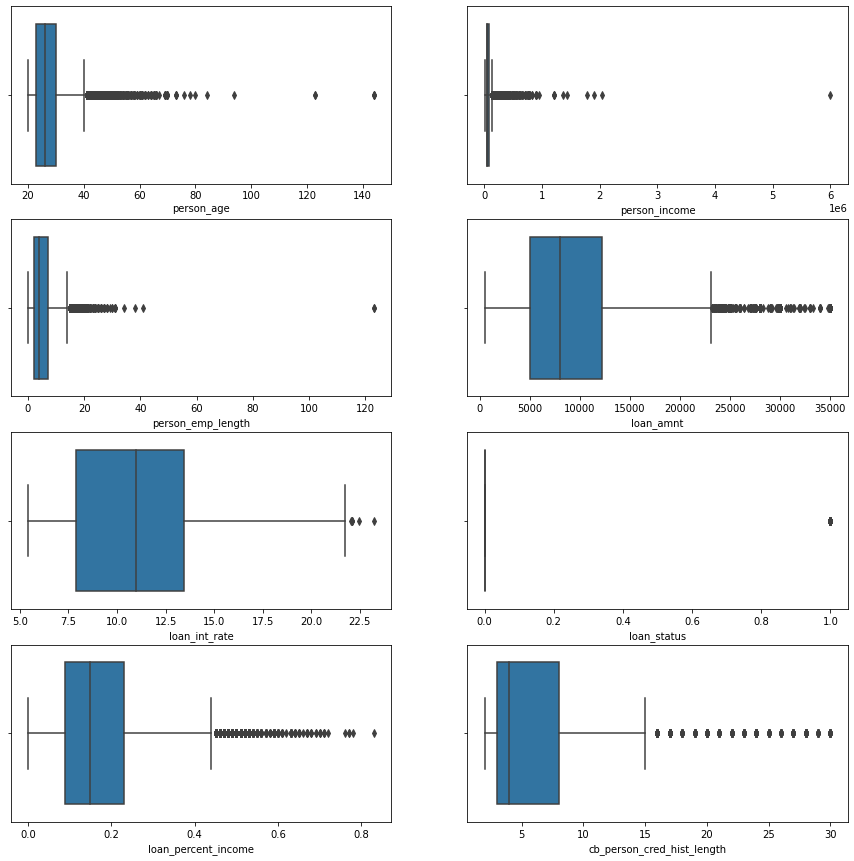

In [11]:
num_cols = df.select_dtypes(np.number).columns              #name of the numeric columns
nrows, ncols = int(np.ceil(len(num_cols)/2)), 2

# Creating subplot axes
fig, axes = plt.subplots(nrows,ncols, figsize=(15, 15))

# Iterating through axes and num_cols
for col, ax in zip(num_cols, axes.flatten()):
    sns.boxplot(x=col, data=df, ax=ax);

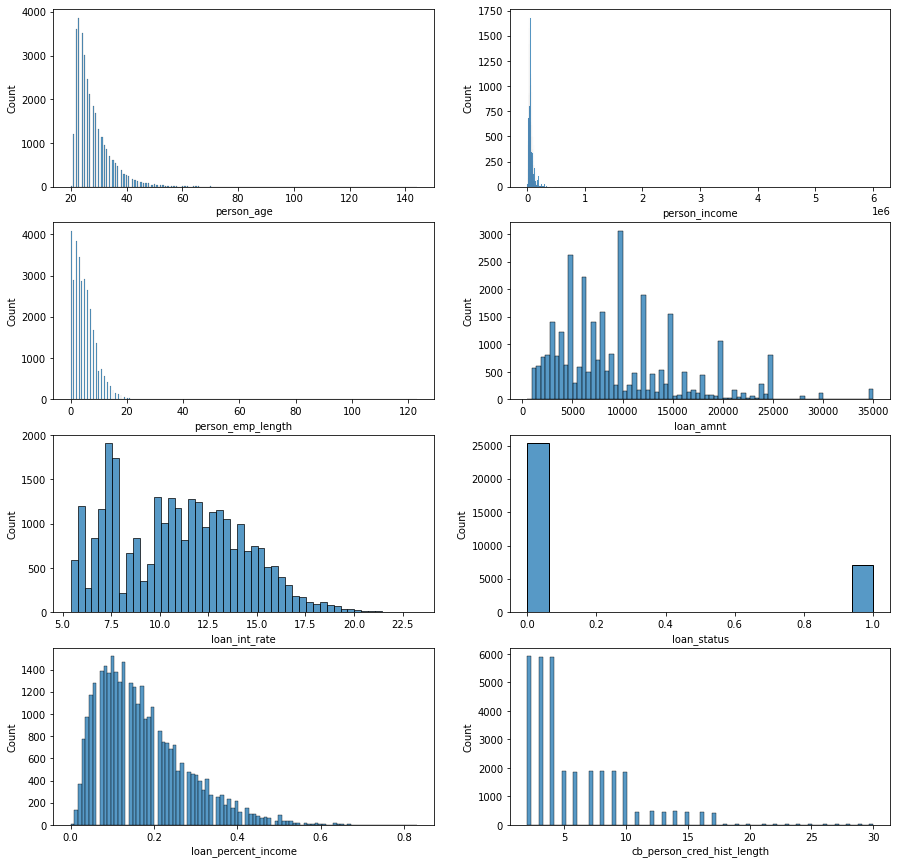

In [12]:
num_cols = df.select_dtypes(np.number).columns
nrows, ncols = int(np.ceil(len(num_cols)/2)), 2

# Creating subplot axes
fig, axes = plt.subplots(nrows,ncols, figsize=(15, 15))

# Iterating through axes and num_cols
for col, ax in zip(num_cols, axes.flatten()):
    sns.histplot(x=col, data=df, ax=ax);

In [13]:
#the minimum and maximum age in the dataset
df.person_age.min(), df.person_age.max()

(20, 144)

In [14]:
# droping some of the outliers
df = df[df['person_age']<=100]
df = df[df['person_emp_length'] <= 60]
df = df[df['person_income']<=4e6]

In [15]:
#checking the number of null values after droping the outliers
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3027
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [16]:
# Kategorik verileri alıyoruz ve one hot encoding haline getiriyoruz
cat_cols = pd.DataFrame(df[df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [17]:
#looking at the values of the person_home_ownership feature
df.person_home_ownership.value_counts()

RENT        16007
MORTGAGE    13018
OWN          2391
OTHER         106
Name: person_home_ownership, dtype: int64

In [18]:
# i am adding a little bit of human bias here
ownership = {"OTHER": 0, "MORTGAGE": 1, "RENT": 2, "OWN": 3}

df["person_home_ownership"] = df["person_home_ownership"].replace(ownership)

In [19]:
#there is an obvious order in the feature values
df["loan_grade"].value_counts()

A    10300
B    10121
C     6301
D     3549
E      951
F      236
G       64
Name: loan_grade, dtype: int64

In [22]:
grade = {"A":6, "B": 5, "C": 4, "D": 3, "E": 2, "F": 1, "G":0}

df["loan_grade"] = df["loan_grade"].replace(grade)

In [20]:
df.loan_intent.value_counts()

EDUCATION            6246
MEDICAL              5869
VENTURE              5518
PERSONAL             5346
DEBTCONSOLIDATION    5044
HOMEIMPROVEMENT      3499
Name: loan_intent, dtype: int64

In [21]:
df.groupby("loan_intent")["loan_status"].value_counts()

loan_intent        loan_status
DEBTCONSOLIDATION  0              3609
                   1              1435
EDUCATION          0              5185
                   1              1061
HOMEIMPROVEMENT    0              2603
                   1               896
MEDICAL            0              4308
                   1              1561
PERSONAL           0              4303
                   1              1043
VENTURE            0              4707
                   1               811
Name: loan_status, dtype: int64

In [23]:
df.cb_person_default_on_file.value_counts()

N    25908
Y     5614
Name: cb_person_default_on_file, dtype: int64

In [24]:
#apply one hot encoding to the rest of the categorical features
df = pd.get_dummies(data=df, columns=["loan_intent", "cb_person_default_on_file"], drop_first=True)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
1,21,9600,3,5.0,5,1000,11.14,0,0.10,2,1,0,0,0,0,0
2,25,9600,1,1.0,4,5500,12.87,1,0.57,3,0,0,1,0,0,0
3,23,65500,2,4.0,4,35000,15.23,1,0.53,2,0,0,1,0,0,0
4,24,54400,2,8.0,4,35000,14.27,1,0.55,4,0,0,1,0,0,1
5,21,9900,3,2.0,6,2500,7.14,1,0.25,2,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1,1.0,4,5800,13.16,0,0.11,30,0,0,0,1,0,0
32577,54,120000,1,4.0,6,17625,7.49,0,0.15,19,0,0,0,1,0,0
32578,65,76000,2,3.0,5,35000,10.99,1,0.46,28,0,1,0,0,0,0
32579,56,150000,1,5.0,5,15000,11.48,0,0.10,26,0,0,0,1,0,0


In [25]:
#encoded_cat_cols = pd.get_dummies(cat_cols)
#df.drop(df.select_dtypes(include=['object']).columns, axis=1,inplace=True)
#df = pd.concat([df,encoded_cat_cols], axis=1)

In [26]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [27]:
# Verileri train ve test olarak ikiye ayırıyoruz

#from sklearn.model_selection import StratifiedShuffleSplit

#split = StratifiedShuffleSplit(1, test_size=0.1)
#train_idx, test_idx = next(split.split(X, y))
#train_x = X[train_idx]
#test_x = X[test_idx]

#train_y = y[train_idx]
#test_y = y[test_idx]

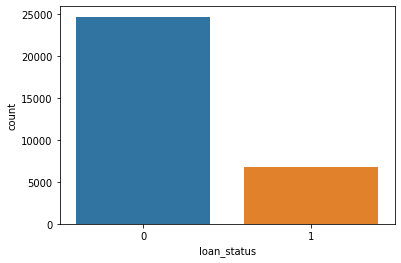

In [28]:
sns.countplot(y);

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify=y, random_state=0)

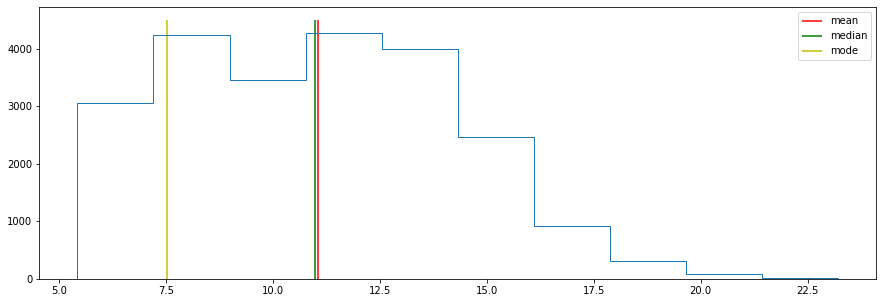

In [30]:
plt.figure(figsize=(15, 5))
plt.hist(X_train.loan_int_rate, histtype="step")
plt.vlines(x=X_train.loan_int_rate.mean(), ymin=0, ymax=4500, label="mean", colors="r")
plt.vlines(x=X_train.loan_int_rate.median(), ymin=0, ymax=4500, label="median", colors="g")
plt.vlines(x=X_train.loan_int_rate.mode()[0], ymin=0, ymax=4500, label="mode", colors="y")
plt.legend()
plt.show()

In [31]:
X_train.loan_int_rate.mean(), X_train.loan_int_rate.median(), X_train.loan_int_rate.mode()[0]

(11.039647120786515, 10.99, 7.51)

In [32]:
X_train["loan_int_rate"] = X_train["loan_int_rate"].fillna(11)
X_test["loan_int_rate"] = X_test["loan_int_rate"].fillna(11)

In [33]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [34]:
# given a dataset automate model building and evaluation
def train_model(X_tr, y_tr, X_te, y_te, model, var=None):

    if var is not None:
        pca = PCA(var)
        X_tr = pca.fit_transform(X_tr)
        X_te = pca.transform(X_te)
    
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    
    return [f1_score(y_te, preds), accuracy_score(y_te, preds), X_tr.shape[1]]

In [35]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, accuracy_score

In [36]:
y_train.value_counts(normalize=True)

0    0.784074
1    0.215926
Name: loan_status, dtype: float64

In [37]:
# deciding on the class weights because they don't seem to be balanced
w0 = 0.215926
w1 = 1 - w0

In [38]:
#models to try with the data
models = {"logistic_regression": LogisticRegression(),
          "random_forest": RandomForestClassifier(random_state=0),
          #"svc": SVC(random_state=0),
          #"svc_weight": SVC(random_state=0, class_weight={0: w0, 1: w1}),
          "naive_bayes": GaussianNB(),
          "lgbm": LGBMClassifier(random_state=0),
          "lgbm_weight": LGBMClassifier(random_state=0, class_weight={0: w0, 1: w1}),
          "lgbm_unbalanced": LGBMClassifier(random_state=0, is_unbalance=True)}

In [39]:
results = []
for var in atpbar([None] + [i for i in np.arange(0.99, 0.74, -0.04, dtype=float)]):
    for k, model in models.items():
        results.append([k, var, *train_model(X_train_s, y_train, X_test_s, y_test, model, var)])

VBox()

In [40]:
results_df = pd.DataFrame(results, columns=["model", "variance", "f1_score", "accuracy_score", "n_components"])
results_df.sort_values("f1_score", ascending=False)

,model,variance,f1_score,accuracy_score,n_components
3,lgbm,NaN,0.832000,0.936717,15
1,random_forest,NaN,0.816548,0.930373,15
4,lgbm_weight,NaN,0.803412,0.915940,15
5,lgbm_unbalanced,NaN,0.803412,0.915940,15
9,lgbm,0.99,0.745791,0.904203,14
13,random_forest,0.95,0.732528,0.901665,11
7,random_forest,0.99,0.731458,0.900079,14
15,lgbm,0.95,0.729193,0.898335,11
19,random_forest,0.91,0.700044,0.891673,10
25,random_forest,0.87,0.700044,0.891673,10
